## Домашнее задание

### Цель задания

1. Обучить простую модель трансформера для обработки любых данных (на выбор: текст, аудио, видео, изображения и ...)
2. Визуализировать веса внимания и интерпретировать их
3. Сделать выводы о том, как модель воспринимает данные и принимает решения

### Решение

#### Импорты

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


#### Обработка датасета

In [ ]:
# Трансформации (нормализация и преобразование в тензор)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Загрузка датасета
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

classes = trainset.classes


Files already downloaded and verified
Files already downloaded and verified


#### Определение модели трансформер

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, num_classes=10, dim=128, depth=6, heads=8, dropout=0.1):
        super(VisionTransformer, self).__init__()
        assert img_size % patch_size == 0, "Image dimensions must be divisible by patch size."
        
        self.patch_dim = 3 * patch_size * patch_size
        self.num_patches = (img_size // patch_size) ** 2
        
        # Преобразование изображения в патчи
        self.patch_embedding = nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, dim))
        self.positional_encoding = nn.Parameter(torch.randn(1, self.num_patches + 1, dim))
        
        # Трансформер
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=dim*4, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.to_cls_token = nn.Identity()
        self.fc_out = nn.Linear(dim, num_classes)
        self.attention_weights = []

    def forward(self, x):
        B = x.shape[0]
        
        x = self.patch_embedding(x) 
        x = x.flatten(2).transpose(1, 2)
        
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.positional_encoding[:, :x.size(1)]

        # Сохраняем внимание
        self.attention_weights = []

        for layer in self.transformer.layers:
            sa = layer.self_attn
            q = k = v = x
            attn_output, attn_weights = sa(q, k, v, need_weights=True, average_attn_weights=False)
            self.attention_weights.append(attn_weights.detach())
            x = layer.norm1(x + attn_output)
            x = layer.norm2(x + layer.linear2(layer.dropout(layer.activation(layer.linear1(x)))))

        x = self.to_cls_token(x[:, 0])
        return self.fc_out(x)


#### Обучение

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_loss, test_accuracy = [], []

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total

def train(model, trainloader, testloader, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(trainloader)
        acc = evaluate(model, testloader)
        train_loss.append(avg_loss)
        test_accuracy.append(acc)
        
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Accuracy: {acc:.4f}")

train(model, trainloader, testloader, epochs=10)


Epoch 1/10 | Loss: 1.8644 | Accuracy: 0.4247
Epoch 2/10 | Loss: 1.5319 | Accuracy: 0.4807
Epoch 3/10 | Loss: 1.4071 | Accuracy: 0.5111
Epoch 4/10 | Loss: 1.3212 | Accuracy: 0.5358
Epoch 5/10 | Loss: 1.2600 | Accuracy: 0.5480
Epoch 6/10 | Loss: 1.2133 | Accuracy: 0.5527
Epoch 7/10 | Loss: 1.1651 | Accuracy: 0.5646
Epoch 8/10 | Loss: 1.1287 | Accuracy: 0.5711
Epoch 9/10 | Loss: 1.0896 | Accuracy: 0.5739
Epoch 10/10 | Loss: 1.0565 | Accuracy: 0.5844


#### Графики лосса и точности предсказаний

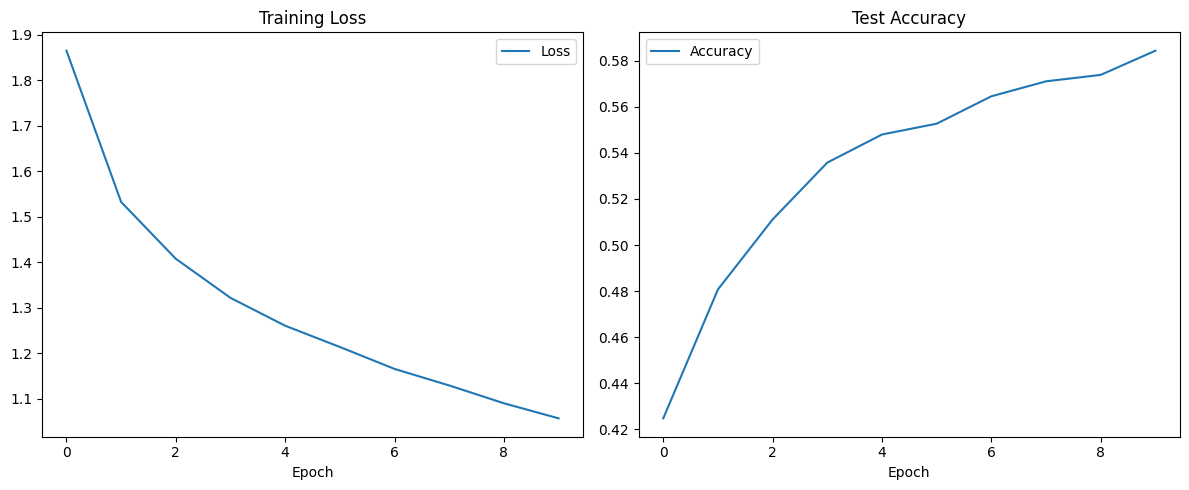

In [5]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracy, label="Accuracy")
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.tight_layout()
plt.show()


#### Визуализация внимания

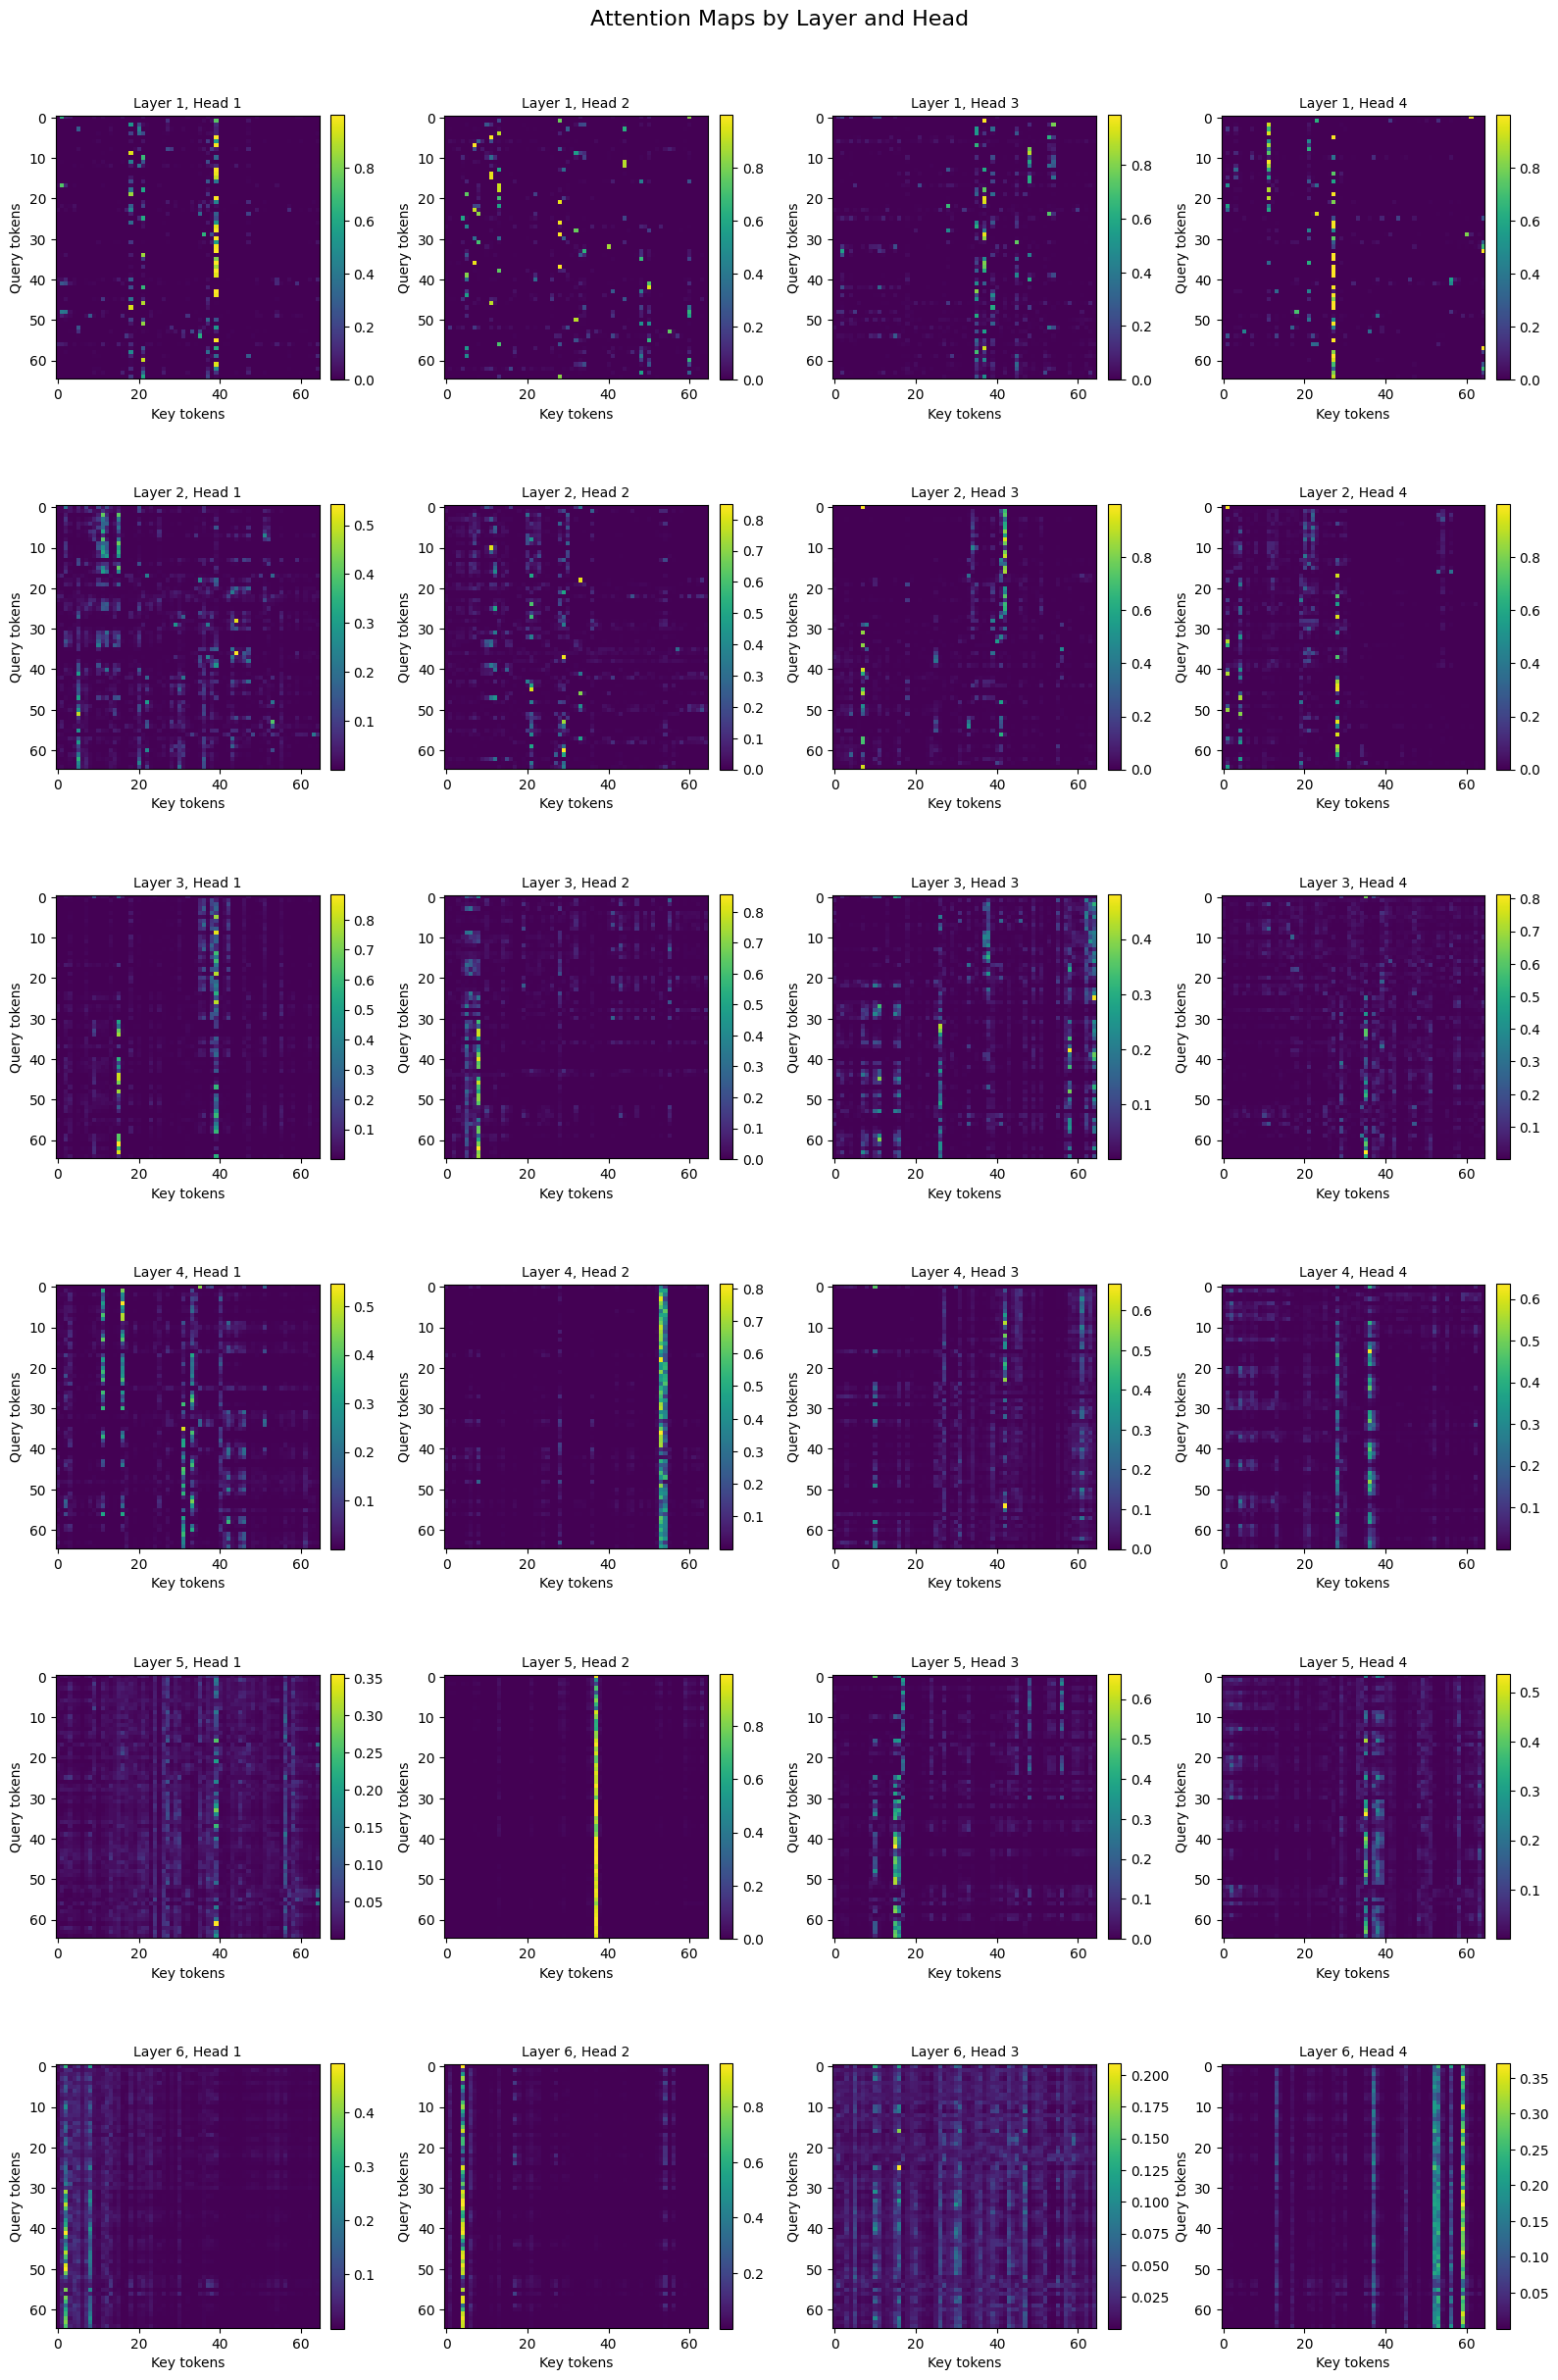

In [ ]:
def plot_attention_grid(attention_weights, max_layers=6, max_heads=4):
    num_layers = min(len(attention_weights), max_layers)
    num_heads = min(attention_weights[0].shape[1], max_heads)
    
    fig, axes = plt.subplots(num_layers, num_heads, figsize=(4*num_heads, 4*num_layers))

    if num_layers == 1:
        axes = [axes]
    if num_heads == 1:
        axes = [[ax] for ax in axes]

    for layer_idx in range(num_layers):
        for head_idx in range(num_heads):
            ax = axes[layer_idx][head_idx]
            attn = attention_weights[layer_idx][0, head_idx].detach().cpu().numpy()

            im = ax.imshow(attn, cmap='viridis')
            ax.set_title(f"Layer {layer_idx+1}, Head {head_idx+1}", fontsize=10)
            ax.set_xlabel("Key tokens")
            ax.set_ylabel("Query tokens")
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.suptitle("Attention Maps by Layer and Head", fontsize=16, y=1.02)
    plt.show()


plot_attention_grid(model.attention_weights, max_layers=6, max_heads=4)

#### Описание графиков
* Каждая маленькая картинка — это матрица внимания для одного слоя и одного хеда
* На каждой картинке 
    * По горизонтали — на что модель смотрит
    * По вертикали — от кого идёт внимание

#### Что мы видим на графиках?
* Видим множество вертикальных линий - это означает, что много запросов обращают внимание на один ключ
* Нижние слои (ближе к входу) — внимание часто локальное, модель фокусируется на мелких деталях
* Верхние слои — внимание может становиться более разбросанным, глобальным, абстрактным
* Видны области внимания

#### Визуализация паттернов внимания

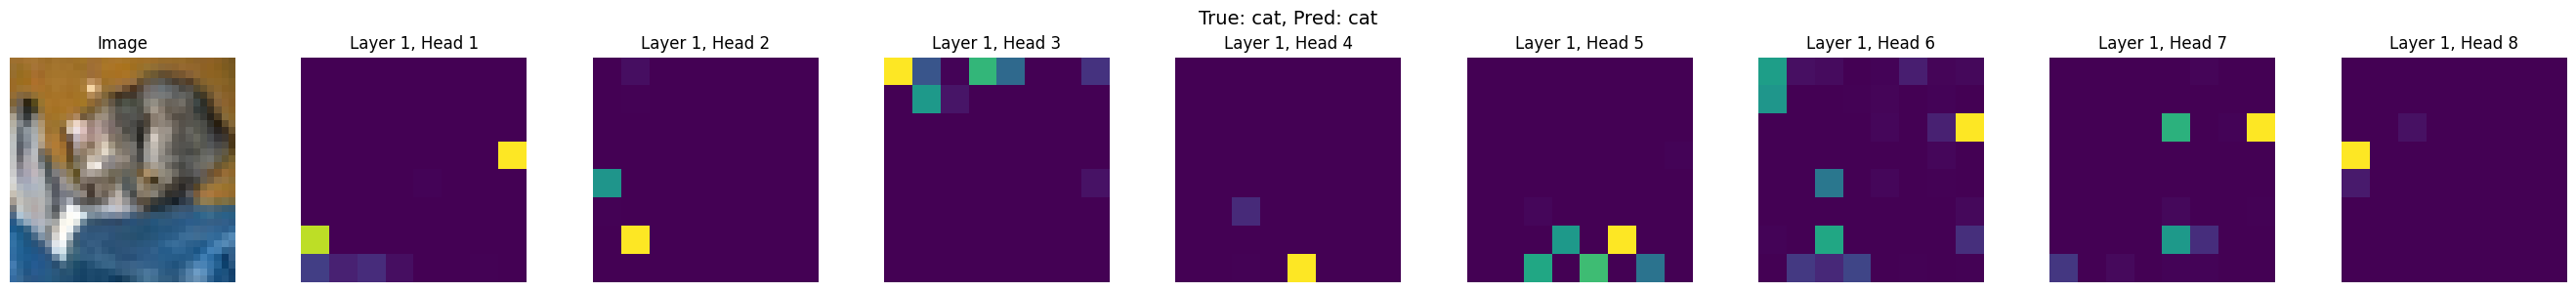

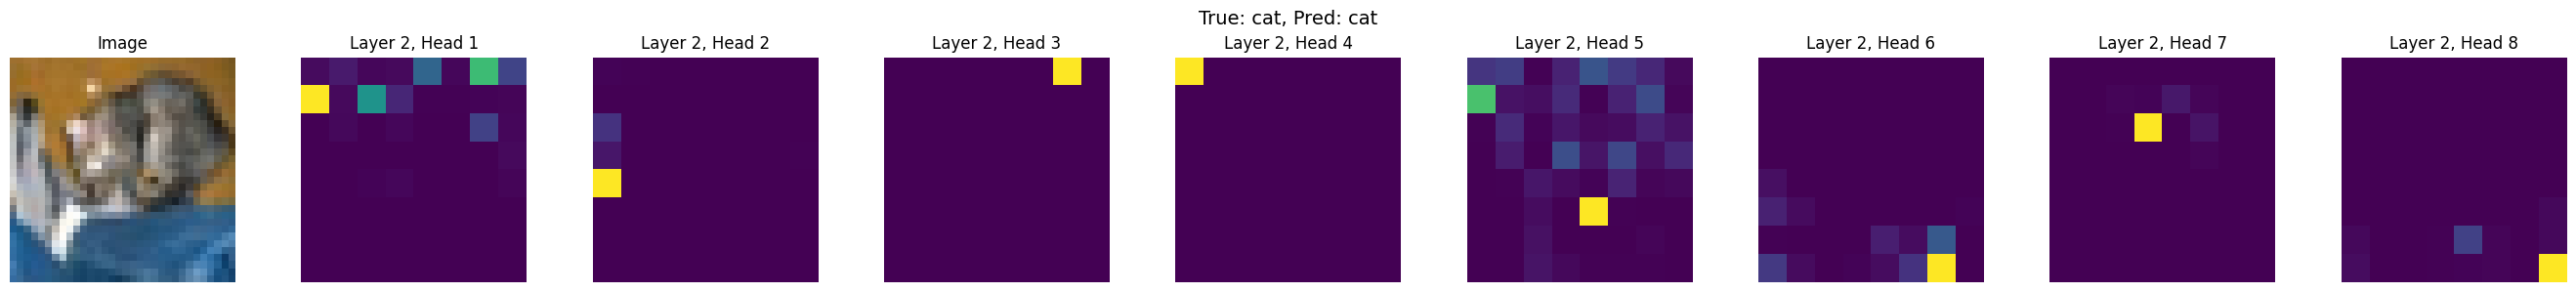

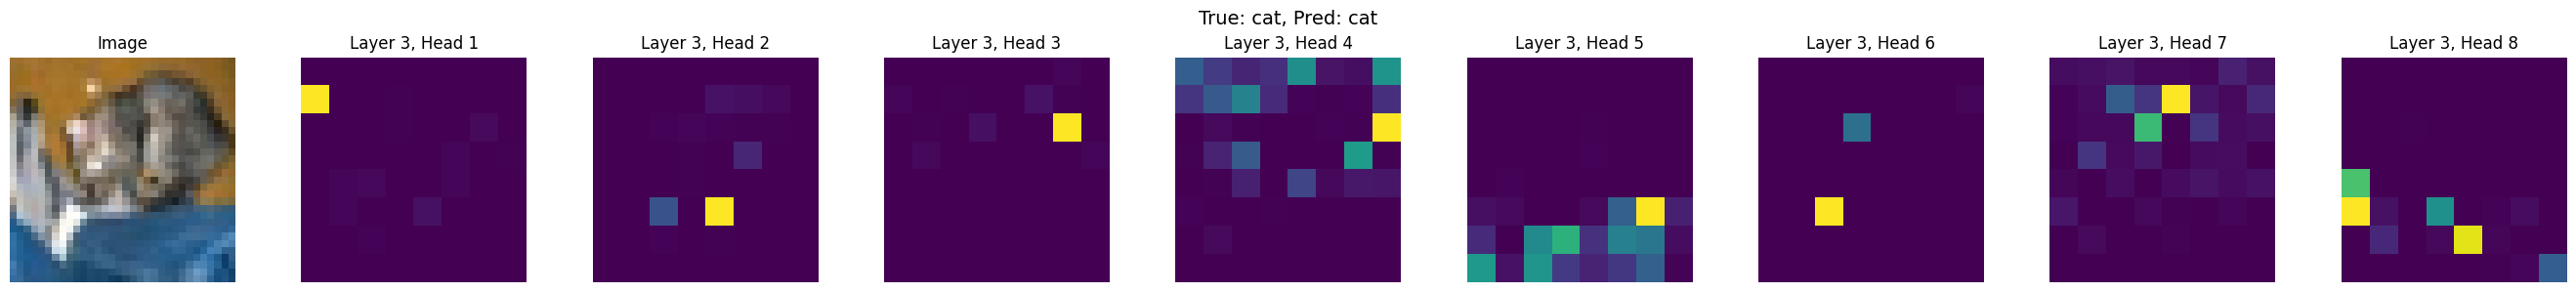

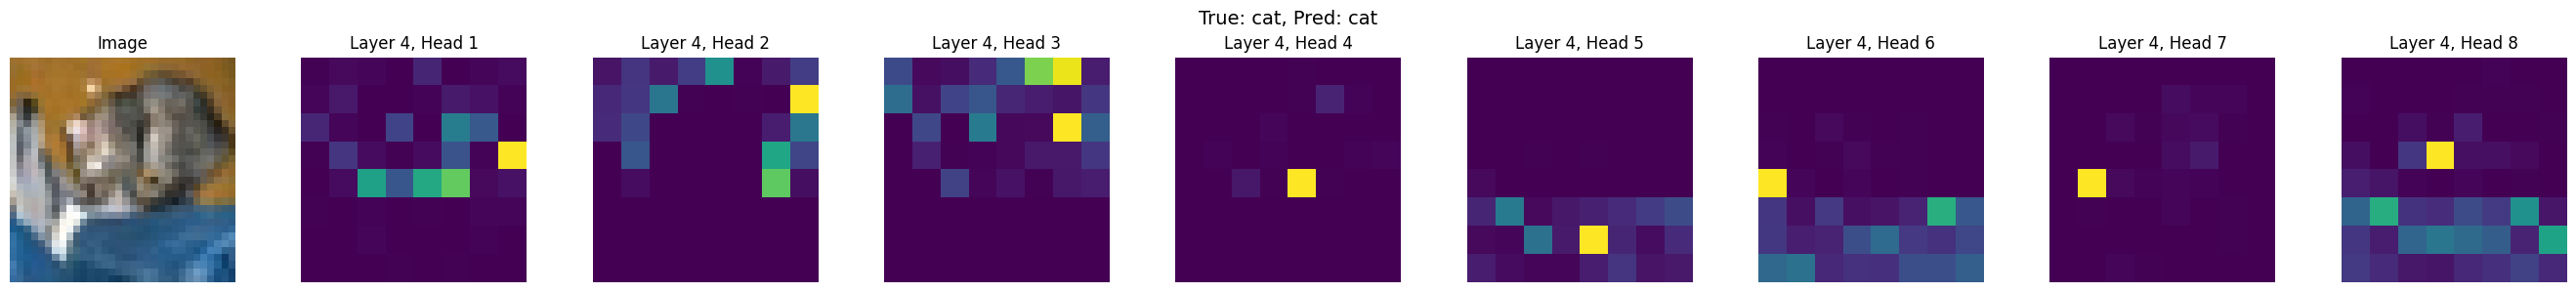

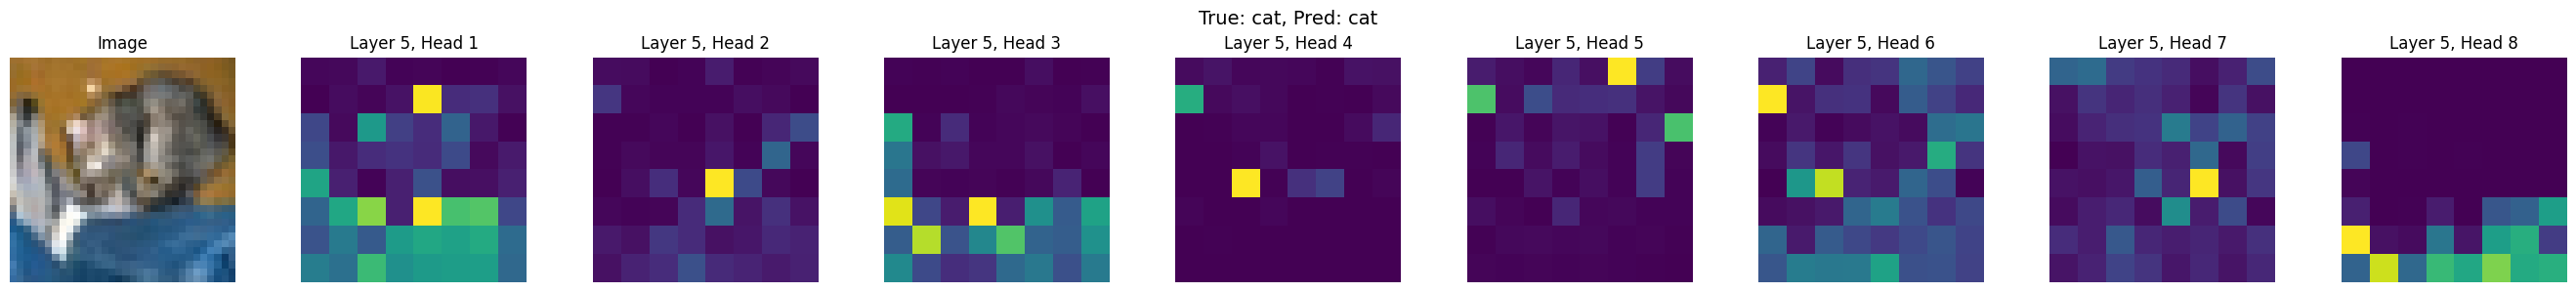

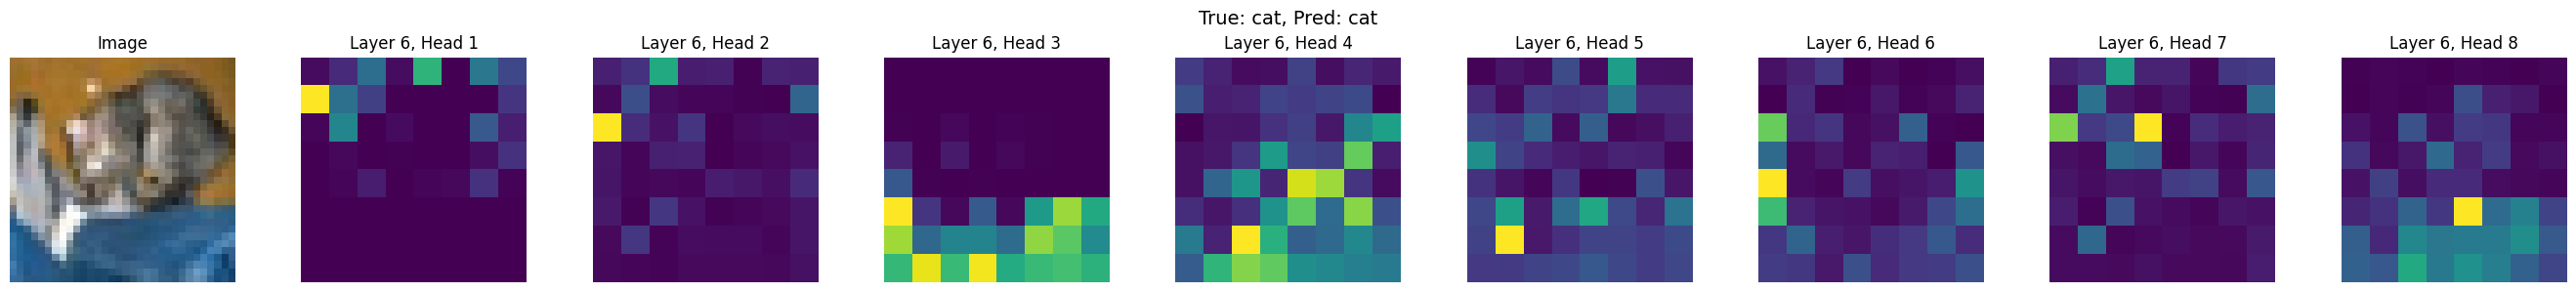

In [ ]:
dataiter = iter(testloader)

# Берём одну картинку из testloader
images, labels = next(dataiter)
img = images[0].unsqueeze(0).to(device)
label = labels[0].item()

# Пропускаем через модель
model.eval()
with torch.no_grad():
    output = model(img)
    pred = torch.argmax(output, dim=1).item()

# Вытаскиваем attention map: (layers, B, heads, seq_len, seq_len)
# Нас интересует: внимание CLS ко всем патчам
attentions = model.attention_weights
cls_attn_maps = []

for layer_attn in attentions:
    attn = layer_attn[0]
    head_attn = attn[:, 0, 1:]  # CLS-токен -> ко всем патчам (без самого CLS)
    cls_attn_maps.append(head_attn.cpu().numpy())

# Количество патчей: 8x8=64
num_heads = cls_attn_maps[0].shape[0]
num_layers = len(cls_attn_maps)
num_patches = cls_attn_maps[0].shape[1]
grid_size = int(np.sqrt(num_patches))

# Восстанавливаем оригинальное изображение для визуализации
img_vis = images[0].permute(1, 2, 0).numpy()
img_vis = (img_vis * 0.5 + 0.5).clip(0, 1)

# Визуализация CLS внимания: 1 слой, все хеды
def plot_cls_attention_heatmaps(cls_attn_maps, img_vis, layer=0):
    fig, axs = plt.subplots(1, num_heads + 1, figsize=(3*(num_heads+1), 3))

    axs[0].imshow(img_vis)
    axs[0].set_title("Image")
    axs[0].axis("off")

    for h in range(num_heads):
        attn = cls_attn_maps[layer][h].reshape(grid_size, grid_size)
        axs[h+1].imshow(attn, cmap='viridis')
        axs[h+1].set_title(f"Layer {layer+1}, Head {h+1}")
        axs[h+1].axis("off")

    plt.suptitle(f"True: {classes[label]}, Pred: {classes[pred]}", fontsize=14)
    plt.tight_layout()
    plt.show()

# Применяем ко всем слоям
for l in range(num_layers):
    plot_cls_attention_heatmaps(cls_attn_maps, img_vis, layer=l)


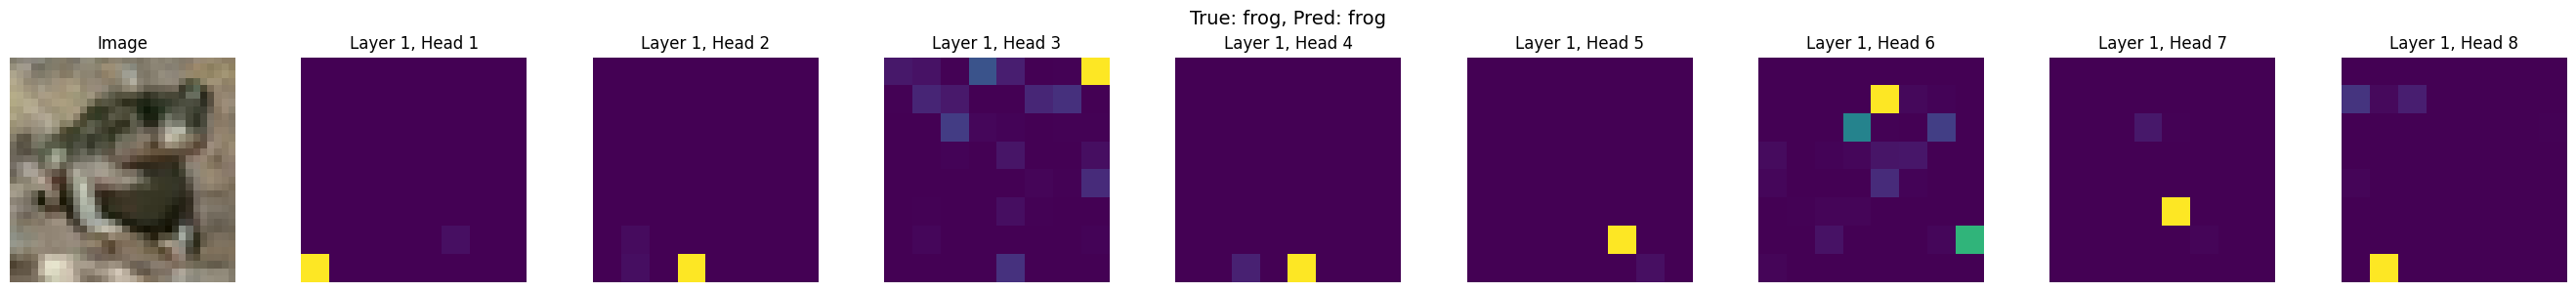

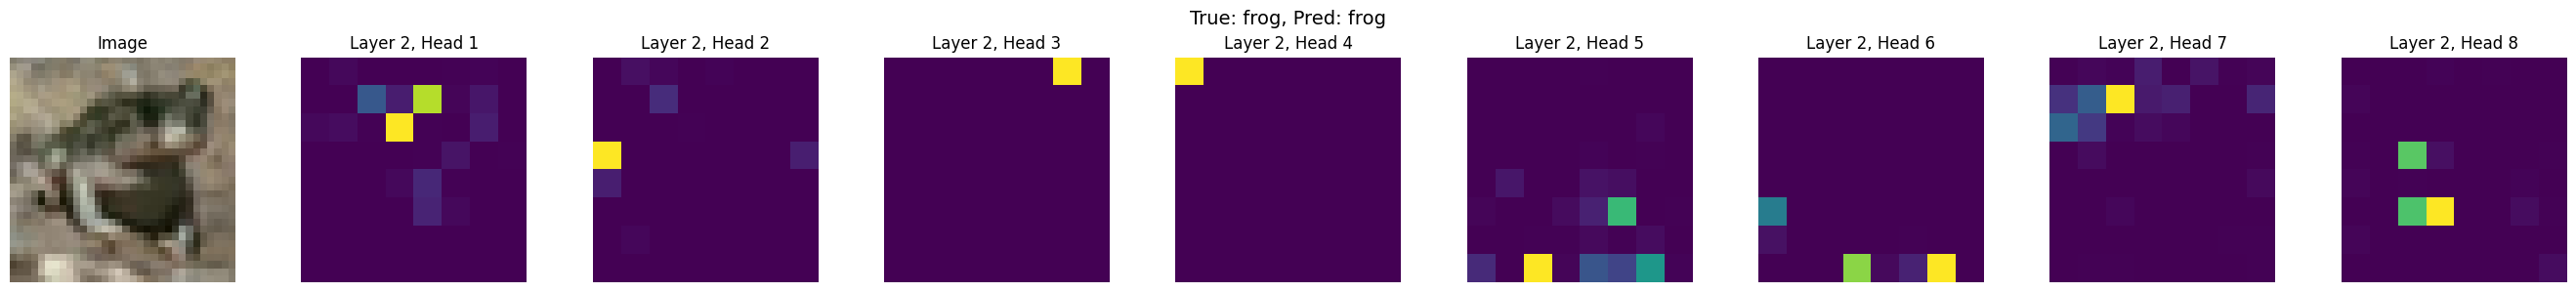

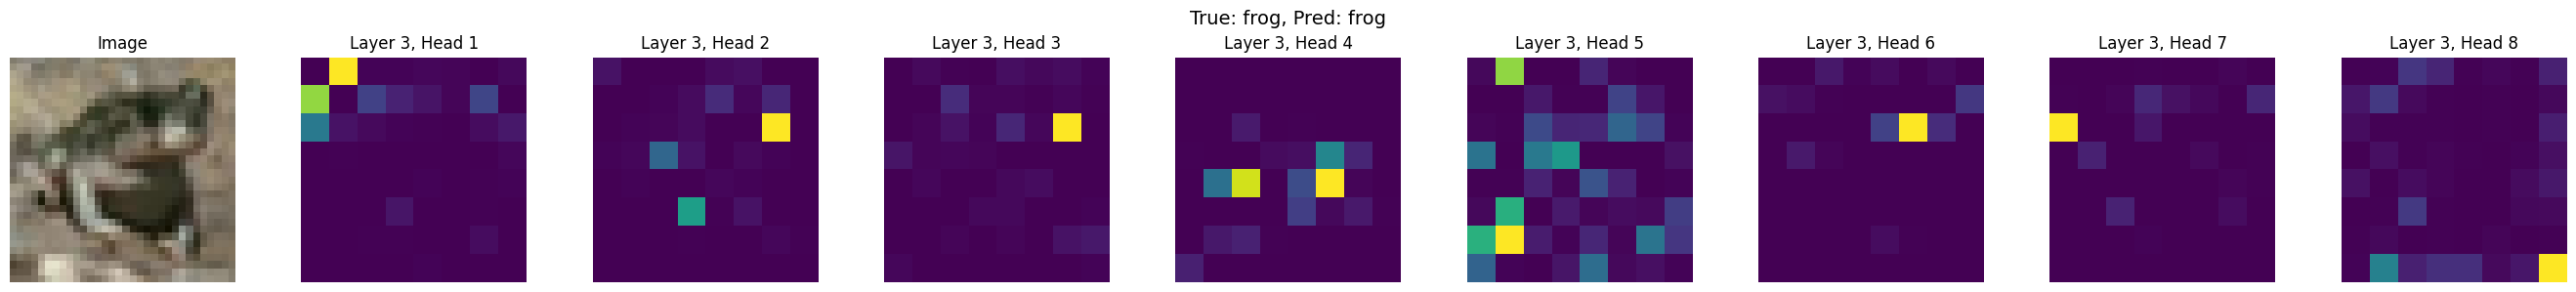

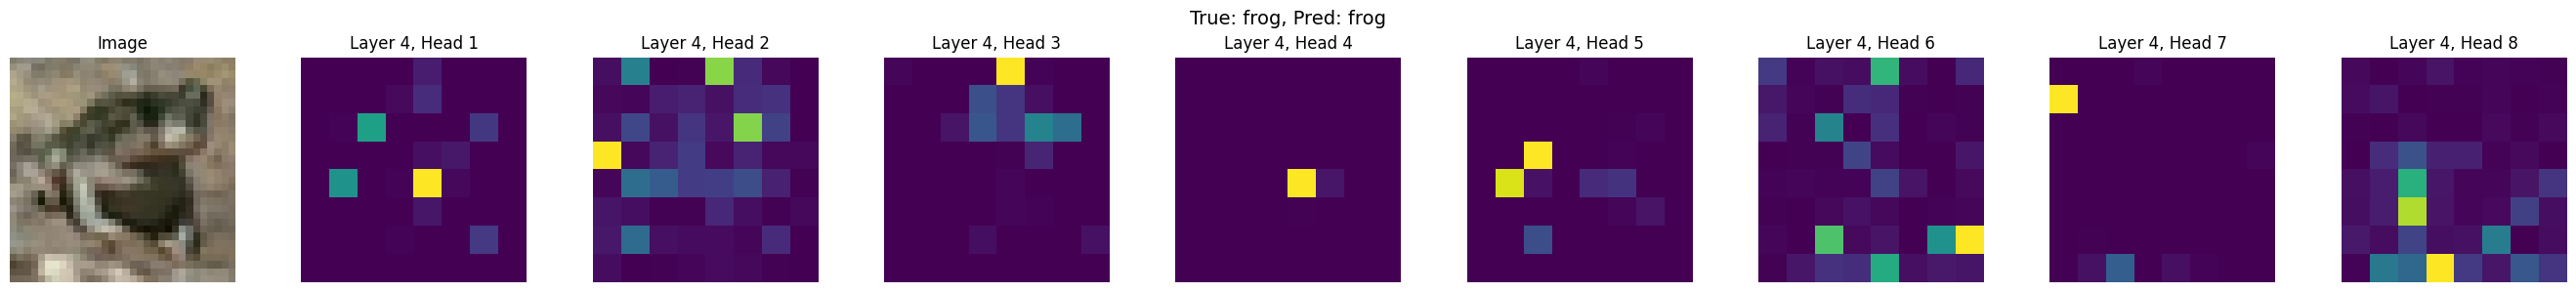

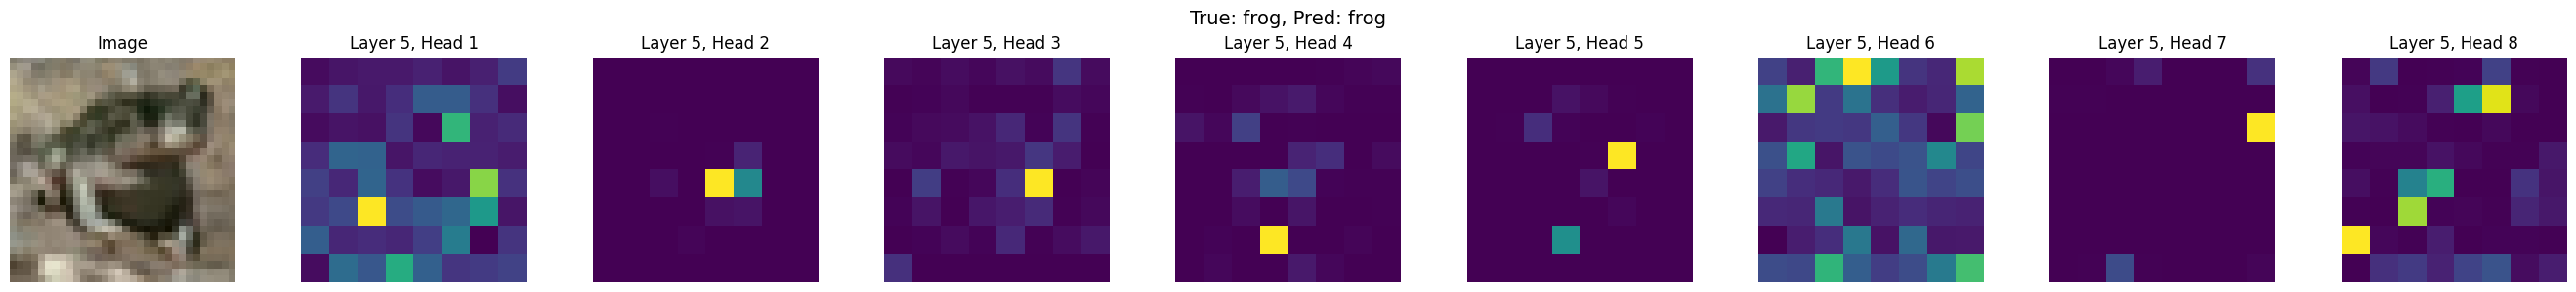

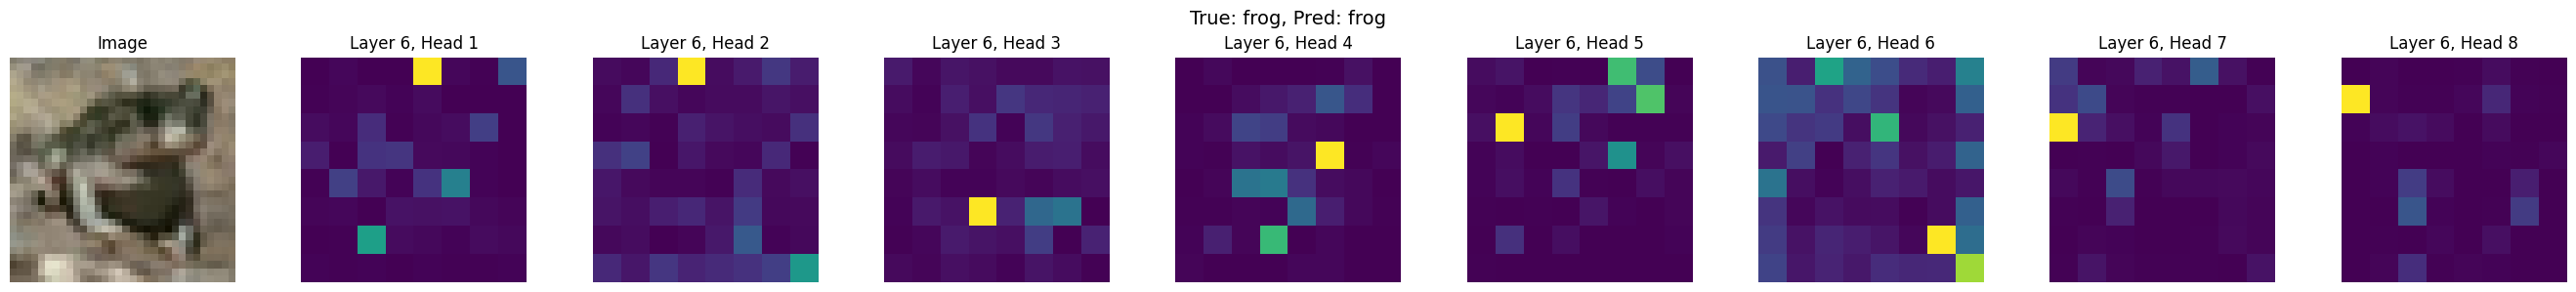

In [ ]:
# Берём одну картинку из testloader
images, labels = next(dataiter)
img = images[0].unsqueeze(0).to(device)
label = labels[0].item()

# Пропускаем через модель
model.eval()
with torch.no_grad():
    output = model(img)
    pred = torch.argmax(output, dim=1).item()

# Вытаскиваем attention map: (layers, B, heads, seq_len, seq_len)
# Нас интересует: внимание CLS ко всем патчам
attentions = model.attention_weights
cls_attn_maps = []

for layer_attn in attentions:
    attn = layer_attn[0]
    head_attn = attn[:, 0, 1:]  # CLS-токен -> ко всем патчам (без самого CLS)
    cls_attn_maps.append(head_attn.cpu().numpy())

# Количество патчей: 8x8=64
num_heads = cls_attn_maps[0].shape[0]
num_layers = len(cls_attn_maps)
num_patches = cls_attn_maps[0].shape[1]
grid_size = int(np.sqrt(num_patches))

# Восстанавливаем оригинальное изображение для визуализации
img_vis = images[0].permute(1, 2, 0).numpy()
img_vis = (img_vis * 0.5 + 0.5).clip(0, 1)

# Визуализация CLS внимания: 1 слой, все хеды
def plot_cls_attention_heatmaps(cls_attn_maps, img_vis, layer=0):
    fig, axs = plt.subplots(1, num_heads + 1, figsize=(3*(num_heads+1), 3))

    axs[0].imshow(img_vis)
    axs[0].set_title("Image")
    axs[0].axis("off")

    for h in range(num_heads):
        attn = cls_attn_maps[layer][h].reshape(grid_size, grid_size)
        axs[h+1].imshow(attn, cmap='viridis')
        axs[h+1].set_title(f"Layer {layer+1}, Head {h+1}")
        axs[h+1].axis("off")

    plt.suptitle(f"True: {classes[label]}, Pred: {classes[pred]}", fontsize=14)
    plt.tight_layout()
    plt.show()

# Применяем ко всем слоям
for l in range(num_layers):
    plot_cls_attention_heatmaps(cls_attn_maps, img_vis, layer=l)


#### Описание графиков
* Видим то, на какие патчи картинки смотрит CLS-токен
* То есть мы видим то, какие части изображения использовались для финального предсказания
* Тёплые цвета (жёлтое/зелёное) — высокая важность патча
* Холодные цвета (синее) — низкое внимание

#### Что мы видим на графиках?
* Визуализируются разные слои трансформера
* Слои глубже - более абстрактные (высокоуровневые) признаки
* В начале CLS может ярко смотрит на отдельные участки
* В конце - видны очертания объектов